In [4]:
import matplotlib.pyplot as plt

(array([0.66353333, 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.99863333, 0.        , 0.        , 0.67116667]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

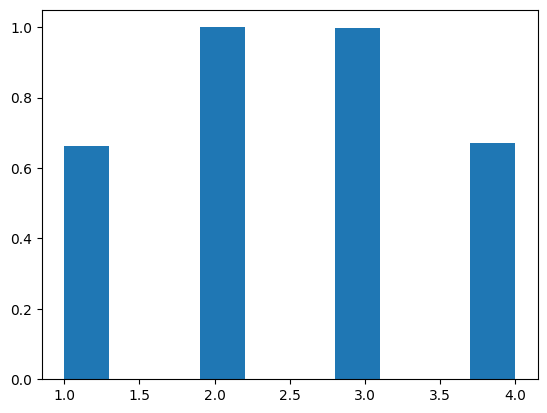

In [26]:
from vose_sampler import VoseAlias
# Example usage
dist = {1: 0.2, 2: 0.3, 3: 0.3, 4: 0.2}
VA = VoseAlias(dist)

# Sample 10 elements
samples = VA.sample_n(size=100000)

# Print the sample (might not reflect the exact probabilities due to randomness)
plt.hist(samples, density=True)


[0 0 1 2 3 4 0 0 0 0 0 1 2 3 5] [1.         0.98867948 0.79444064 0.75448421 0.84736775 0.71596335
 0.98997885 0.9317448  0.8799812  0.8336664  0.79198308 0.7542696
 0.71998462 0.68868094 0.6599859 ]


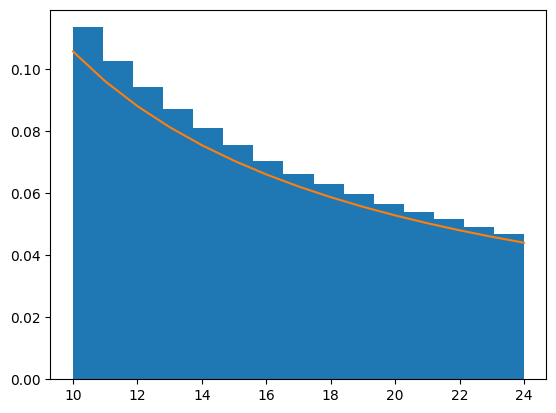

In [81]:
import numpy as np

def build_alias(probas):
    values = np.arange(len(probas)).tolist()
    dist = {v: p for v,p in zip(values, probas.tolist())}
    va = VoseAlias(dist)
    alias = va.table_alias
    thresholds = {k: float(i) for k,i in va.table_prob.items()}
    alias = np.array([(alias[i] if i in alias else i) for i in values])
    thresholds = np.array([(thresholds[i] if i in thresholds else 1.0) for i in values])
    return alias, thresholds


def sample(alias, thr, remap=None, num_samples=1):
    index = np.random.randint(0, len(alias), size=(num_samples))
    unif = np.random.uniform(0,1, size=(num_samples))
    res = np.where(unif > thr[index], alias[index], index)
    if remap is not None:
        return remap[res]

v = np.arange(10, 25)
p = 1 / v # np.ones_like(v).astype(float)
p /= p.sum()



alias, thr = build_alias(p)
print(alias, thr)
plt.hist(sample(alias, thr, v, 1_000_000), bins=len(alias), density=True)
plt.plot(v, p)

In [82]:
import numpy as np
import pyopencl as cl
import pyopencl.array as cl_array


# Initialize PyOpenCL
platform = cl.get_platforms()[0]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)

# Define kernel function to generate random numbers using Philox
kernel_code = open("./alias.cl").read()

# Compile kernel function
program = cl.Program(context, kernel_code).build()

# Set up output buffer
output_buffer = cl_array.zeros(queue, 1_000_000, dtype=np.uint64)

# Execute kernel
program.generate_random_numbers(queue, output_buffer.shape, None, output_buffer.data, np.uint32(123))

# Read output buffer
output = output_buffer.get()

# Print generated random numbers
print("Generated random numbers:")
print(output)

LogicError: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR